In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
import time
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.sparse import csr_matrix
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

#特征重要性
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
 
#聚合求count
def feature_count(data, features=[]):
    if len(set(features)) != len(features):
        print('equal feature !!!!')
        return data
    new_feature = 'count'
    for i in features:
        new_feature += '_' + i.replace('add_', '')
    try:
        del data[new_feature]
    except:
        pass
    temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
    data = data.merge(temp, 'left', on=features)
    new_num_features.append(new_feature)
    return data    



In [2]:
train = pd.read_csv('../input/train_dataset.csv')
test = pd.read_csv('../input/test_dataset.csv')

#删除id
test_id = test['用户编码'].copy()

train.drop("用户编码", axis = 1, inplace = True)
test.drop("用户编码", axis = 1, inplace = True)

label = train['信用分'].copy()
train.drop(['信用分'], axis=1, inplace=True)


#特征工程
data = pd.concat([train, test])

#原始的类别和数值特征
ori_cat_features = ['用户实名制是否通过核实','是否大学生客户','是否黑名单客户','是否4G不健康客户','缴费用户当前是否欠费缴费','是否经常逛商场的人','当月是否逛过福州仓山万达',
                    '当月是否到过福州山姆会员店','当月是否看电影','当月是否景点游览','当月是否体育场馆消费']
ori_num_features = ['用户年龄','用户网龄（月）','用户最近一次缴费距今时长（月）','缴费用户最近一次缴费金额（元）','用户近6个月平均消费值（元）','用户账单当月总费用（元）',
                    '用户当月账户余额（元）','用户话费敏感度','当月通话交往圈人数','近三个月月均商场出现次数','当月网购类应用使用次数','当月物流快递类应用使用次数',
                    '当月金融理财类应用使用总次数','当月视频播放类应用使用次数','当月飞机类应用使用次数','当月火车类应用使用次数','当月旅游资讯类应用使用次数']
ori_col = data.columns.tolist()
                    
#对年龄异常值取众数填充
data.loc[data['用户年龄']==0, '用户年龄'] = data['用户年龄'].mode()

#对金额相关特征做组合
data['缴费金额是否能覆盖当月账单'] = data['缴费用户最近一次缴费金额（元）'] - data['用户账单当月总费用（元）']
data['最近一次交费是否超过平均消费额'] = data['缴费用户最近一次缴费金额（元）'] - data['用户近6个月平均消费值（元）']
data['当月账单是否超过平均消费额'] = data['用户账单当月总费用（元）'] - data['用户近6个月平均消费值（元）']
data['缴费习惯'] = data['缴费用户最近一次缴费金额（元）'] / (data['用户近6个月平均消费值（元）'] + 1)
data['最近账单稳定性'] = data['用户账单当月总费用（元）'] / (data['用户近6个月平均消费值（元）'] + 1)
data['费用/余额'] = data['用户账单当月总费用（元）'] / (data['缴费用户最近一次缴费金额（元）'] + 1)
data['账户余额利用率'] = data['用户账单当月总费用（元）'] / (data['用户当月账户余额（元）'] + 1)

#对次数特征做组合
data['交通类应用使用次数'] = data['当月飞机类应用使用次数'] + data['当月火车类应用使用次数']

new_num_features = [i for i in data.columns.tolist() if i not in ori_col]

#充值金额是整数，和小数，应该对应不同的充值途径
data['充值方式'] = 0
data['充值方式'][(data['缴费用户最近一次缴费金额（元）'] % 10 == 0) & data['缴费用户最近一次缴费金额（元）'] != 0] = 1

#对类别特征进行组合，是否可以得出更好的结果
data['是否去过高档商场'] = data['当月是否逛过福州仓山万达'] + data['当月是否到过福州山姆会员店']
data['是否去过高档商场'] = data['是否去过高档商场'].map(lambda x:1 if x>=1 else 0)
data['是否_商场_电影'] = data['是否去过高档商场'] * data['当月是否看电影']
data['是否_商场_旅游'] = data['是否去过高档商场'] * data['当月是否景点游览']
data['是否_商场_体育馆'] = data['是否去过高档商场'] * data['当月是否体育场馆消费']
data['是否_电影_体育馆'] = data['当月是否看电影'] * data['当月是否体育场馆消费']
data['是否_电影_旅游'] = data['当月是否看电影'] * data['当月是否景点游览']
data['是否_旅游_体育馆'] = data['当月是否景点游览'] * data['当月是否体育场馆消费']
data['是否_商场_旅游_体育馆'] = data['是否去过高档商场'] * data['当月是否景点游览'] * data['当月是否体育场馆消费']
data['是否_商场_电影_体育馆'] = data['是否去过高档商场'] * data['当月是否看电影'] * data['当月是否体育场馆消费']
data['是否_商场_电影_旅游'] = data['是否去过高档商场'] * data['当月是否看电影'] * data['当月是否景点游览']
data['是否_体育馆_电影_旅游'] = data['当月是否体育场馆消费'] * data['当月是否看电影'] * data['当月是否景点游览']
data['是否_商场_体育馆_电影_旅游'] = data['是否去过高档商场'] * data['当月是否体育场馆消费'] * data['当月是否看电影'] * data['当月是否景点游览']

new_cat_features = [i for i in data.columns.tolist() if i not in ori_col and i not in new_num_features]

#对一些特征分段
discretize_features=['交通类应用使用次数','当月物流快递类应用使用次数','当月飞机类应用使用次数','当月火车类应用使用次数','当月旅游资讯类应用使用次数']
def map_discretize(x):
        if x==0:
            return 0
        elif x<=5:
            return 1
        elif x<=15:
            return 2
        elif x<=50:
            return 3
        elif x<=100:
            return 4
        else:
            return 5
        
for col in discretize_features:
    data[col]=data[col].map(lambda x:map_discretize(x))

#离散化
transform_value_feature=['用户年龄','用户网龄（月）','当月通话交往圈人数','近三个月月均商场出现次数','当月网购类应用使用次数','当月物流快递类应用使用次数'
                            ,'当月金融理财类应用使用总次数','当月视频播放类应用使用次数','当月飞机类应用使用次数','当月火车类应用使用次数','当月旅游资讯类应用使用次数']
user_fea=['缴费用户最近一次缴费金额（元）','用户近6个月平均消费值（元）','用户账单当月总费用（元）','用户当月账户余额（元）']
log_features=['当月网购类应用使用次数','当月金融理财类应用使用总次数','当月物流快递类应用使用次数','当月视频播放类应用使用次数']

for col in transform_value_feature+log_features:
    #取出最高99.9%值
    ulimit=np.percentile(data[col].values,99.9)
    #取出最低0.1%值
    llimit=np.percentile(data[col].values,0.1)
    data.loc[data[col]>ulimit,col]=ulimit
    data.loc[data[col]<llimit,col]=llimit
    
for col in user_fea+transform_value_feature+log_features:
    data[col]=data[col].map(lambda x:np.log1p(x))
    
#聚合特征
# data = feature_count(data, ['用户年龄'])
# data = feature_count(data, ['用户网龄（月）'])
# data = feature_count(data, ['用户最近一次缴费距今时长（月）'])
# data = feature_count(data, ['缴费用户最近一次缴费金额（元）'])
# data = feature_count(data, ['用户近6个月平均消费值（元）'])
# data = feature_count(data, ['用户账单当月总费用（元）'])
# data = feature_count(data, ['用户话费敏感度'])
# data = feature_count(data, ['当月通话交往圈人数'])
# data = feature_count(data, ['近三个月月均商场出现次数'])
# data = feature_count(data, ['最近一次交费是否超过平均消费额'])
# data = feature_count(data, ['当月账单是否超过平均消费额'])

# data = feature_count(data, ['用户话费敏感度','用户年龄'])
# data = feature_count(data, ['用户话费敏感度','用户网龄（月）'])
# data = feature_count(data, ['用户话费敏感度','用户最近一次缴费距今时长（月）'])
# data = feature_count(data, ['用户话费敏感度','缴费用户最近一次缴费金额（元）'])
# data = feature_count(data, ['用户话费敏感度','用户近6个月平均消费值（元）'])
# data = feature_count(data, ['用户话费敏感度','用户账单当月总费用（元）'])
# data = feature_count(data, ['用户话费敏感度','当月通话交往圈人数'])
# data = feature_count(data, ['用户话费敏感度','近三个月月均商场出现次数'])
# data = feature_count(data, ['用户话费敏感度','最近一次交费是否超过平均消费额'])
# data = feature_count(data, ['用户话费敏感度','当月账单是否超过平均消费额'])

# #聚合其他列的特征
# sparse_feature = ['用户年龄','用户网龄（月）','用户最近一次缴费距今时长（月）','用户话费敏感度']
# dense_feature = ['缴费用户最近一次缴费金额（元）','用户近6个月平均消费值（元）','用户账单当月总费用（元）',
#                     '用户当月账户余额（元）']

# def get_new_columns(name,aggs):
#     l=[]
#     for k in aggs.keys():
#         for agg in aggs[k]:
#             if str(type(agg))=="<class 'function'>":
#                 l.append(name + '_' + k + '_' + 'other')
#             else:
#                 l.append(name + '_' + k + '_' + agg)
#     return l
# for d in tqdm(sparse_feature):
#     aggs={}
#     for s in sparse_feature:
#         aggs[s]=['count','nunique']
#     for den in dense_feature:
#         aggs[den]=['mean','max','min','std']
#     aggs.pop(d)
#     temp=data.groupby(d).agg(aggs).reset_index()
#     temp.columns=[d]+get_new_columns(d,aggs)
#     new_num_features.append(get_new_columns(d,aggs))
#     data=pd.merge(data,temp,on=d,how='left')

#记录特征
cat_features = new_cat_features + ori_cat_features
num_features = new_num_features + ori_num_features

for i in cat_features:
    data[i] = data[i].astype('category')
for i in num_features:
    data[i] = data[i].astype('float')

# #类别特征做one-hot    
# for feature in cat_features:
#     try:
#         data[feature] = LabelEncoder().fit_transform(data[feature].apply(int))
#     except:
#         data[feature] = LabelEncoder().fit_transform(data[feature])    
 

train = data[:train.shape[0]]
test = data[train.shape[0]:]    


# train_x=train[num_features]
# test_x=test[num_features]
# enc = OneHotEncoder()
# for feature in cat_features:
#     enc.fit(data[feature].values.reshape(-1, 1))
#     train_a= enc.transform(train[feature].values.reshape(-1, 1))
#     test_a = enc.transform(test[feature].values.reshape(-1, 1))
#     train= sparse.hstack((train_x, train_a), 'csr')
#     test = sparse.hstack((test_x, test_a), 'csr')
    
    
# #CountVectorizer()特征,在本题中没有合适的量
# vector_feature = []
# # for i in vector_feature:
# #     data[i] = data[i].astype('str')
# #     train[i] = train[i].astype('str')
# #     test[i] = test[i].astype('str')

    

# cv=CountVectorizer()
# for feature in vector_feature:
#     cv.fit(data[feature])
#     train_a = cv.transform(train[feature])
#     test_a = cv.transform(test[feature])
#     train = sparse.hstack((train_x, train_a), 'csr')
#     test = sparse.hstack((test_x, test_a), 'csr')


#开始训练
# kf = StratifiedKFold(n_splits=5, random_state=2019, shuffle=False)
# training_time = 0 
# feature_importance_df = pd.DataFrame()
# best_score = []
# sub_list = []

# clf = lgb.LGBMRegressor(
#           boosting_type='gbdt', num_leaves=31, reg_alpha=2.2, reg_lambda=1.5,
#           max_depth=-1, n_estimators=2000,
#           subsample=0.8, colsample_bytree=0.7, subsample_freq=1,
#           learning_rate=0.03, random_state=2019, n_jobs=-1)

# for i, (train_index, val_index) in enumerate(kf.split(train, label)):
#      t0 = time.time()
#      X_train, y_train = train.loc[train_index,:], label[train_index]
#      X_val, y_val     = train.loc[val_index,:],   label[val_index]
#      #X_train, y_train = train[train_index], label[train_index]
#      #X_val,    y_val   = train[val_index],   label[val_index]
#      #clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],\
#       #        eval_metric='mae', early_stopping_rounds=200, verbose=200, categorical_feature=cat_features)
#      clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],\
#               eval_metric='mae', early_stopping_rounds=200, verbose=200)
#      pred_val = clf.predict(X_val, num_iteration=clf.best_iteration_)
#      vali_mae = mean_absolute_error(y_val, np.round(pred_val))
#      best_score.append(1/(1+vali_mae))
#      pred_test = clf.predict(test,num_iteration=clf.best_iteration_)
     
#      fold_importance_df = pd.DataFrame()
#      fold_importance_df["feature"] = list(X_train.columns)
#      fold_importance_df["importance"] = clf.feature_importances_
#      fold_importance_df["fold"] = i + 1
#      feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
     
#      sub_list.append(pred_test)
#      t = (time.time() - t0) / 60
#      training_time += t
     
#      print("This round cost time:{:.2f} minutes, lgb scor:{:.8f},\n".format(t, 1/(1+vali_mae)))
        
# pred_test = np.mean(np.array(sub_list), axis=0)
# print(best_score, '\n', np.mean(best_score), np.std(best_score))
# print("Total training time cost:{:.2f} minutes".format(training_time))  


In [3]:
#para
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': -1,
    'reg_alpha':2.2,
    'reg_lambda':1.4,
    'nthread': 8
}


from sklearn.model_selection import KFold
cv_pred_all = 0
en_amount = 3

oof_lgb1=np.zeros(len(train))
prediction_lgb1=np.zeros(len(test))

for seed in range(en_amount):
    NFOLDS = 5
    
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    kf = kfold.split(train, label)

    cv_pred = np.zeros(test.shape[0])
    valid_best_l2_all = 0

    feature_importance_df = pd.DataFrame()
    count = 0
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = \
        train.iloc[train_fold, :], train.iloc[validate, :], \
        label[train_fold], label[validate]
        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid, verbose_eval=-1,early_stopping_rounds=250)
        cv_pred += bst.predict(test, num_iteration=bst.best_iteration)
        valid_best_l2_all += bst.best_score['valid_0']['l1']
        
        oof_lgb1[validate]=bst.predict(X_validate,num_iteration=bst.best_iteration)
        prediction_lgb1+=bst.predict(test,num_iteration=bst.best_iteration)/kfold.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = list(X_train.columns)
        fold_importance_df["importance"] = bst.feature_importance(importance_type='split', iteration=bst.best_iteration)
        fold_importance_df["fold"] = count + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

    cv_pred /= NFOLDS
    valid_best_l2_all /= NFOLDS
    
    cv_pred_all += cv_pred
cv_pred_all /= en_amount
prediction_lgb1/=en_amount
print('cv score for valid is: ', 1/(1+valid_best_l2_all))

fold:  0  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[2876]	valid_0's l1: 14.7649
fold:  1  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3578]	valid_0's l1: 14.7411
fold:  2  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[2875]	valid_0's l1: 14.5537
fold:  3  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[4786]	valid_0's l1: 14.5669
fold:  4  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[4860]	valid_0's l1: 14.7279
fold:  0  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[2593]	valid_0's l1: 14.6226
fold:  1  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[2863]	valid_0's l1: 14.6552
fold:  2  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[4675]	valid_0's l1: 14.551
fold:  3  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3238]	valid_0's l1: 14.7203
fold:  4  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3090]	valid_0's l1: 14.7746
fold:  0  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[4006]	valid_0's l1: 14.785
fold:  1  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3270]	valid_0's l1: 14.8511
fold:  2  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[2482]	valid_0's l1: 14.4975
fold:  3  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[3411]	valid_0's l1: 14.6189
fold:  4  training


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[2890]	valid_0's l1: 14.605
cv score for valid is:  0.06381009171459795


In [4]:
prediction_lgb1[:10]

array([603.09614014, 532.96661418, 672.08055813, 674.48973062,
       657.97941674, 616.70868529, 640.82691618, 572.06478992,
       674.00512066, 585.72954064])

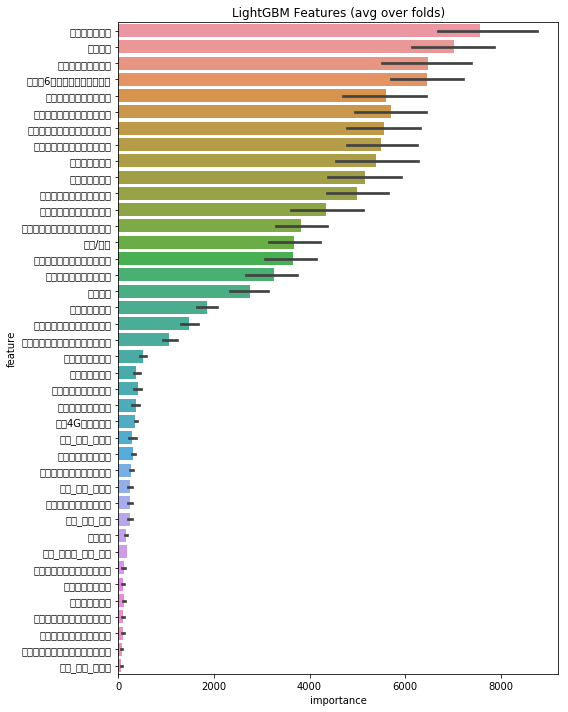

In [5]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
display_importances(feature_importance_df)

In [6]:
cols.head(30)

,importance
feature,
用户网龄（月）,7573.0
用户年龄,7024.2
当月通话交往圈人数,6482.6
用户近6个月平均消费值（元）,6449.2
当月视频播放类应用使用次数,5696.0
当月网购类应用使用次数,5592.0
当月金融理财类应用使用总次数,5546.6
当月账单是否超过平均消费额,5498.0
账户余额利用率,5393.4


In [7]:
for i in cat_features:
    train[i] = train[i].astype('int')
    test[i]  = test[i].astype('int')

import xgboost as xgb
xgb_params={'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 8}
from sklearn.model_selection import KFold
cv_pred_allxgb=0
en_amount=3
oof_xgb1=np.zeros(len(train))
prediction_xgb1=np.zeros(len(test))
for seed in range(en_amount):
    NFOLDS=5
    kfold=KFold(n_splits=NFOLDS, shuffle=True, random_state=seed+2019)
    kf=kfold.split(train,label)
    
    cv_pred = np.zeros(test.shape[0])
    valid_best_l2_all = 0
    
    feature_importance_df = pd.DataFrame()
    count = 0
    
    for i, (train_fold, validate) in enumerate(kf):
        print('fold: ',i, ' training')
        X_train, X_validate, label_train, label_validate = train.iloc[train_fold, :], train.iloc[validate, :], label[train_fold], label[validate]
        dtrain = xgb.DMatrix(X_train, label_train)
        dvalid = xgb.DMatrix(X_validate, label_validate)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid_data')]
        bst = xgb.train(dtrain=dtrain, num_boost_round=10000, evals=watchlist, early_stopping_rounds=250, verbose_eval=300, params=xgb_params)
        cv_pred += bst.predict(xgb.DMatrix(test), ntree_limit=bst.best_ntree_limit)
        oof_xgb1[validate]=bst.predict(xgb.DMatrix(X_validate),ntree_limit=bst.best_ntree_limit)
        prediction_xgb1+=bst.predict(xgb.DMatrix(test),ntree_limit=bst.best_ntree_limit)/kfold.n_splits
        count += 1
        
    cv_pred /= NFOLDS
    cv_pred_allxgb+=cv_pred
cv_pred_allxgb /= en_amount
prediction_xgb1/=en_amount

fold:  0  training
[0]	train-mae:614.394	valid_data-mae:614.763
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 250 rounds.
[300]	train-mae:136.718	valid_data-mae:136.797
[600]	train-mae:31.7283	valid_data-mae:32.5587
[900]	train-mae:13.9201	valid_data-mae:16.1642
[1200]	train-mae:11.7989	valid_data-mae:14.8642
[1500]	train-mae:11.0662	valid_data-mae:14.7237
[1800]	train-mae:10.484	valid_data-mae:14.6969
[2100]	train-mae:9.94332	valid_data-mae:14.6862
[2400]	train-mae:9.4513	valid_data-mae:14.6809
[2700]	train-mae:8.99636	valid_data-mae:14.6833
Stopping. Best iteration:
[2450]	train-mae:9.37312	valid_data-mae:14.6799

fold:  1  training
[0]	train-mae:614.314	valid_data-mae:615.104
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 250 rounds.
[300]	train-mae:136.7	valid_data-mae:137.128
[600]	train-mae:3

In [8]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb1,oof_xgb1]).transpose()
test_stack = np.vstack([prediction_lgb1, prediction_xgb1]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2019)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])
target=label
for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_absolute_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


14.656277072807658

In [9]:
len(test_id)

50000

In [10]:
test_data_sub1 = pd.DataFrame()
test_data_sub1['id'] = test_id
test_data_sub1['score'] =  predictions
test_data_sub1.columns = ['id','score']
test_data_sub1['lgb_score'] = cv_pred_all

In [11]:
test_data_sub1['score'] = test_data_sub1['score'].apply(lambda x: int(np.round(x)))

In [12]:
test_data_sub1.head()

,id,score,lgb_score
0,7171737d49b143d1b38883a39e4a5730,601,603.096140
1,3af0a449d5424488912e8fb2bf4b9faa,529,532.966614
2,eb2cf02e0d5c4d1294dd73e776dbb441,670,672.080558
3,9c0f780ecb254670a11aa9e3f10777c5,675,674.489731
4,d794eed46c1e44f785a575f18b3023a5,659,657.979417


In [13]:
test_data_sub1[['id','score']].to_csv('lgb_xgb_stacking.csv', index=False)